In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, log_loss, classification_report, confusion_matrix
from collections import Counter

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

###Data Loading

###All data

In [ ]:
df = pd.read_csv('fully_processed_data.csv')
df = df.drop('Unnamed: 0', axis=1)
df.head()

,myear,calcage,leader,deputy,support,disabled,hired,sherpa,tibetan,msuccess,mclaimed,mdisputed,msolo,mtraverse,mski,mparapente,mspeed,mo2none,mo2climb,mo2descent,mo2sleep,mo2medical,death,hcn,host,totmembers,tothired,nohired,citizen_is_nation,hired_ratio,same_nat_as_leader,prev_summit,prev_attempt,0,1,2,3,4,5,6,...,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483
0,1988,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,17,10,0,1,0.588235,1,0,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1988,40,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,17,10,0,0,0.588235,0,1,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1988,29,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,17,10,0,0,0.588235,0,1,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1988,27,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,17,10,0,0,0.588235,0,0,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1988,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,10,0,0,0.588235,0,1,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
y_summit = df.msuccess
y_death = df.death
X = df.drop(['msuccess', 'death', 'prev_summit', 'prev_attempt'], axis=1)

### Split by year data

In [ ]:
# random sample of 6 years for 30 modern years to check exped overtraining
test_years = np.random.choice(range(1990,2020), size = 6,replace=False)
test_string = ''
for year in test_years:
  test_string = test_string + 'myear == ' + str(year) + ' or '
test_string = test_string[:-4]
train_string = test_string.replace('==', '!=').replace('or','and')

test_data = df.query(test_string)
train_data = df.query(train_string + ' and myear >= 1990')

In [ ]:
y_mod_summit_train = train_data.msuccess
y_mod_summit_valid = test_data.msuccess
y_mod_death_train = train_data.death
y_mod_death_valid = test_data.death

X_mod_summit_train = train_data.drop(['msuccess', 'death', 'myear',
                                      'prev_summit', 'prev_attempt'], axis=1)
X_mod_summit_valid = test_data.drop(['msuccess', 'death', 'myear','prev_summit',
                                     'prev_attempt'], axis=1)

###Utility Functions

In [ ]:
def graph_and_stats(model, X_valid, y_valid):
  
  predictions = model.predict(X_valid)

  print("Log Loss:", log_loss(y_valid, predictions), "\n")

  confusion = confusion_matrix(y_valid, predictions)

  # calculating all the required stats for full understanding
  acc = (confusion[0][0] + confusion[1][1])/ (confusion[0][0]
      + confusion[0][1] + confusion[1][0] + confusion[1][1])
  ner = (confusion[0][0] + confusion[0][1]) / (confusion[1][0]
        + confusion[1][1])
  missclass = (confusion[0][1] + confusion[1][0]) / (
      confusion[0][0] + confusion[0][1] + confusion[1][0] +
      confusion[1][1])
  tpr = confusion[1][1] / (confusion[1][0] + confusion[1][1])
  fpr = confusion[0][1] / (confusion[0][0] + confusion[0][1])
  tnr = confusion[0][0] / (confusion[0][0] + confusion[0][1])
  fnr = confusion[1][0] / (confusion[1][0] + confusion[1][1])
  prc = confusion[1][1] / (confusion[0][1] + confusion[1][1])
  b_acc = (tpr+tnr) / 2
  f_measure = 2 * ((tpr * prc) / (tpr + prc))

  print("Accuracy:", acc)
  print("Balenced Accuracy:", b_acc)
  print("Null error rate:", ner)
  print("Error rate:", missclass)
  print("True Positive Rate:", tpr) # Sensitivity also recall
  print("False Positive Rate:", fpr) 
  print("True Negitive Rate:", tnr) # Specificty
  print("False Negitive Rate:", fnr)
  print("Precision:", prc)
  print("F-measure:", f_measure, '\n')

  plt.figure(figsize=(15, 6))
  plt.matshow(confusion, cmap = 'Blues')

  group_names = ['True Negative','False Positive','False Negative',
                 'True Positive']
  group_counts = ["{0:0.0f}".format(value) for value in
                confusion.flatten()]
  group_percentages = ["{0:0.2f} %".format(value) for value in
                     confusion.flatten()/np.sum(confusion)*100]

  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)

  sns.heatmap(confusion, annot=labels, fmt = '',
            cmap='Blues') # ,cbar = False)

  plt.ylabel("Truth")
  plt.xlabel("Prediction")
  
  plt.tick_params(bottom = True, top = False, labelbottom = True,
                  labeltop = False)
  plt.grid(True, which = 'minor')
  
  #plt.savefig("Graphs/.png", bbox_inches='tight', dpi=600)
  

##Summit

In [ ]:
X_summit_train,X_summit_valid,y_summit_train,y_summit_valid = train_test_split(
    X, y_summit, train_size=0.8, test_size=0.2, random_state=0)

In [ ]:
summit_model = XGBClassifier(
                             early_stopping_rounds=10,
                             lr = 0.05,
                             n_estimators=1000,
                             verbosity=1,
                             max_deapth=4
                             )

summit_model.fit(X_summit_train, y_summit_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=10,
              gamma=0, learning_rate=0.1, lr=0.05, max_deapth=4,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
              n_estimators=1000, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

Log Loss: 3.222742596094652 

Accuracy: 0.9066937119675457
Null error rate: 0.9879032258064516
Error rate: 0.09330628803245436
True Positive Rate: 0.9576612903225806
False Positive Rate: 0.14489795918367346
True Negitive Rate: 0.8551020408163266
False Negitive Rate: 0.04233870967741935
Precision: 0.86996336996337
F-measure: 0.9117082533589252 



<Figure size 1080x432 with 0 Axes>

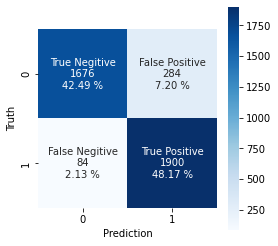

In [ ]:
graph_and_stats(summit_model, X_summit_valid, y_summit_valid)

##Modern Summiting Optimisation

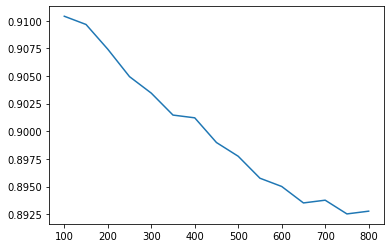

In [ ]:
# model tuning

# NEEDS TO BE REDONE

# n_estimators 650 peak
# early stopping rounds has no effect, keeping default
# lr no effect keeping 0.05
# subsample around 0.86 
# colsample_bytree around 0.65
# gamma 0 is best

acc = []
for i in [100,150,200,250,300,350,400,450,500,550,600,650,700,750,800]:
  temp_model = XGBClassifier(
                             early_stopping_rounds=10,
                             lr = 0.05,
                             n_estimators=i,
                             verbosity=1,
                             max_deapth=3,
                             subsample = 0.85,
                             colsample_bytree = 0.65,
                             gamma = 1
                             ).fit(X_mod_summit_train, y_mod_summit_train)
  temp_predictions = temp_model.predict(X_mod_summit_valid)
  acc.append(accuracy_score(y_mod_summit_valid, temp_predictions))

plt.figure()
plt.plot([100,150,200,250,300,350,400,450,500,550,600,650,700,750,800], acc)

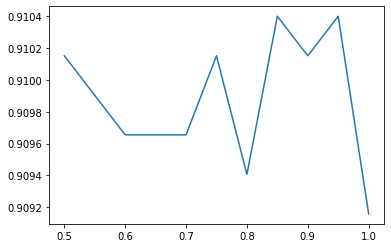

In [ ]:
acc = []
for i in [0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]:
  temp_model = XGBClassifier(
                             early_stopping_rounds=10,
                             lr = 0.05,
                             n_estimators=100,
                             verbosity=1,
                             max_deapth=3,
                             subsample = i,
                             colsample_bytree = 0.65,
                             gamma = 1
                             ).fit(X_mod_summit_train, y_mod_summit_train)
  temp_predictions = temp_model.predict(X_mod_summit_valid)
  acc.append(accuracy_score(y_mod_summit_valid, temp_predictions))

plt.figure()
plt.plot([0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1], acc)
plt.ylabel("Model Accuracy")

##Modern Summiting

In [ ]:
sampler = RandomUnderSampler(random_state = 0, replacement=True)

X_mod_summit_train,y_mod_summit_train = sampler.fit_resample(X_mod_summit_train,
                                                            y_mod_summit_train)

# Getting data in the right format
X_mod_summit_train = pd.DataFrame(X_mod_summit_train,
                                   columns=train_data.drop(['msuccess', 'death',
                                                            'myear',
                                                            'prev_summit',
                                                            'prev_attempt'],
                                                           axis=1).columns)
y_mod_summit_train = pd.Series(y_mod_summit_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# optimised model
summit_mod_model = XGBClassifier(
                             early_stopping_rounds=10,
                             lr = 0.05,
                             n_estimators=650,
                             verbosity=1,
                             max_deapth=3,
                             subsample = 0.85,
                             colsample_bytree = 0.65,
                             gamma = 0
                             )

summit_mod_model.fit(X_mod_summit_train, y_mod_summit_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.65,
              early_stopping_rounds=10, gamma=0, learning_rate=0.1, lr=0.05,
              max_deapth=3, max_delta_step=0, max_depth=3, min_child_weight=1,
              missing=None, n_estimators=650, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=0.85, verbosity=1)

Log Loss: 3.67767936338078 

Accuracy: 0.8935219657483247
Balenced Accuracy: 0.8865905795177016
Null error rate: 0.772547294324681
Error rate: 0.10647803425167536
True Positive Rate: 0.9406071271447426
False Positive Rate: 0.1674259681093394
True Negitive Rate: 0.8325740318906606
False Negitive Rate: 0.05939287285525737
Precision: 0.8791118421052632
F-measure: 0.9088204038257173 



<Figure size 1080x432 with 0 Axes>

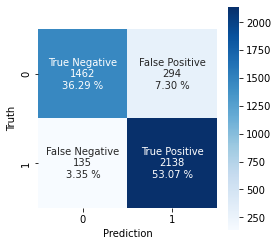

In [ ]:
graph_and_stats(summit_mod_model, X_mod_summit_valid, y_mod_summit_valid)

Log Loss: 2.964183731137071 

Accuracy: 0.9141797481455926
Balenced Accuracy: 0.9141797481455926
Null error rate: 1.0
Error rate: 0.08582025185440745
True Positive Rate: 0.9715370018975332
False Positive Rate: 0.14317750560634812
True Negitive Rate: 0.8568224943936519
False Negitive Rate: 0.028462998102466792
Precision: 0.8715567935623646
F-measure: 0.9188351415286728 



<Figure size 1080x432 with 0 Axes>

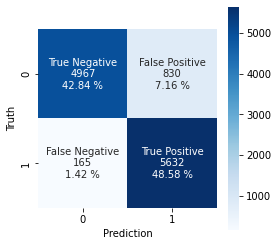

In [ ]:
graph_and_stats(summit_mod_model, X_mod_summit_train, y_mod_summit_train)

##Summiting Modern Year Splitting

In [ ]:
test = df.query('myear > 2014')
train = df.query('myear <= 2014 and myear > 1990')

y_mod_summit_train = train.msuccess
y_mod_summit_test = test.msuccess
X_mod_summit_train = train.drop(['msuccess', 'death', 'myear'], axis=1)
X_mod_summit_test = test.drop(['msuccess', 'death', 'myear'], axis=1)

In [ ]:
summit_mod_model = XGBClassifier(
                             early_stopping_rounds=10,
                             lr = 0.05,
                             n_estimators=650,
                             verbosity=1,
                             max_deapth=3,
                             subsample = 0.85,
                             colsample_bytree = 0.65,
                             gamma = 0
                             )

summit_mod_model.fit(X_mod_summit_train, y_mod_summit_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.65,
              early_stopping_rounds=10, gamma=0, learning_rate=0.1, lr=0.05,
              max_deapth=3, max_delta_step=0, max_depth=3, min_child_weight=1,
              missing=None, n_estimators=650, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=0.85, verbosity=1)

Log Loss: 2.499158392843772 

Accuracy: 0.9276433691756273
Null error rate: 0.47619047619047616
Error rate: 0.07235663082437276
True Positive Rate: 0.9834656084656085
False Positive Rate: 0.18958333333333333
True Negitive Rate: 0.8104166666666667
False Negitive Rate: 0.016534391534391533
Precision: 0.9159223898983677
F-measure: 0.9484930633072874 



<Figure size 1080x432 with 0 Axes>

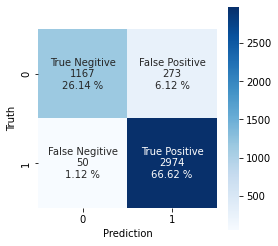

In [ ]:
graph_and_stats(summit_mod_model, X_mod_summit_test, y_mod_summit_test)

##Death

In [ ]:
y_death_train = y_mod_death_train
y_death_valid = y_mod_death_valid
X_death_train = X_mod_summit_train
X_death_valid = X_mod_summit_valid

In [ ]:
death_model = XGBClassifier(
                            early_stopping_rounds=10,
                            lr = 0.05,
                            n_estimators=1000,
                            verbosity=1,
                            max_deapth=4
                            )

death_model.fit(X_death_train, y_death_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=10,
              gamma=0, learning_rate=0.1, lr=0.05, max_deapth=4,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
              n_estimators=1000, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

Log Loss: 0.5582267160103972 

Accuracy: 0.9838376891334251
Balenced Accuracy: 0.5304373585740697
Null error rate: 58.3469387755102
Error rate: 0.016162310866574967
True Positive Rate: 0.061224489795918366
False Positive Rate: 0.0003497726477789437
True Negitive Rate: 0.9996502273522211
False Negitive Rate: 0.9387755102040817
Precision: 0.75
F-measure: 0.11320754716981131 



<Figure size 1080x432 with 0 Axes>

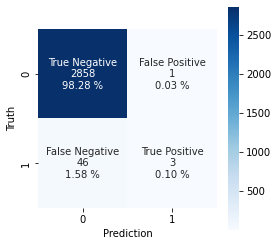

In [ ]:
graph_and_stats(death_model, X_death_valid, y_death_valid)

Log Loss: 0.19848451341069592 

Accuracy: 0.994253286401839
Balenced Accuracy: 0.6937621967121711
Null error rate: 106.91472868217055
Error rate: 0.005746713598161052
True Positive Rate: 0.3875968992248062
False Positive Rate: 7.250580046403712e-05
True Negitive Rate: 0.999927494199536
False Negitive Rate: 0.6124031007751938
Precision: 0.9803921568627451
F-measure: 0.5555555555555556 



<Figure size 1080x432 with 0 Axes>

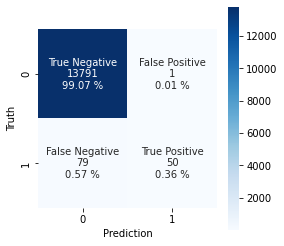

In [ ]:
graph_and_stats(death_model, X_death_train, y_death_train)

##Death with weights

In [ ]:
y_death_train.value_counts()

0    15537
1      238
Name: death, dtype: int64

In [ ]:
class_counts = y_death_train.value_counts()

class_ratio = class_counts[0]/class_counts[1]

death_weight_model = XGBClassifier(
                            early_stopping_rounds=10,
                            lr = 0.05,
                            n_estimators=1000,
                            verbosity=1,
                            max_deapth=4,
                            scale_pos_weight = class_ratio
                            )

death_weight_model.fit(X_death_train, y_death_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=10,
              gamma=0, learning_rate=0.1, lr=0.05, max_deapth=4,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
              n_estimators=1000, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=106.91472868217055, seed=None,
              silent=None, subsample=1, verbosity=1)

Log Loss: 1.591564786615902 

Accuracy: 0.953920220082531
Balenced Accuracy: 0.5653682249395036
Null error rate: 58.3469387755102
Error rate: 0.04607977991746905
True Positive Rate: 0.16326530612244897
False Positive Rate: 0.03252885624344176
True Negitive Rate: 0.9674711437565582
False Negitive Rate: 0.8367346938775511
Precision: 0.07920792079207921
F-measure: 0.10666666666666667 



<Figure size 1080x432 with 0 Axes>

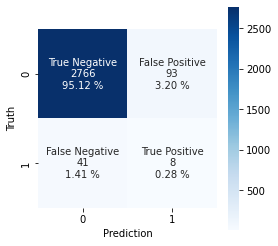

In [ ]:
graph_and_stats(death_weight_model, X_death_valid, y_death_valid)

Log Loss: 0.9998885945631337 

Accuracy: 0.9710509302492637
Balenced Accuracy: 0.9853900812064965
Null error rate: 106.91472868217055
Error rate: 0.028949069750736297
True Positive Rate: 1.0
False Positive Rate: 0.02921983758700696
True Negitive Rate: 0.970780162412993
False Negitive Rate: 0.0
Precision: 0.2424812030075188
F-measure: 0.39031770045385783 



<Figure size 1080x432 with 0 Axes>

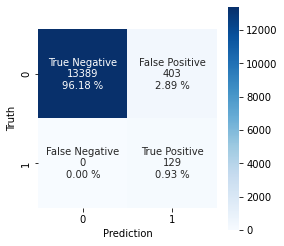

In [ ]:
graph_and_stats(death_weight_model, X_death_train, y_death_train)

##Death with undersampling


In [ ]:
sampler = RandomUnderSampler(random_state = 0, replacement=True)

X_death_resampled_u, y_death_resampled_u = sampler.fit_resample(X_death_train,
                                                            y_death_train)

# Getting data in the right format
X_death_resampled_u = pd.DataFrame(X_death_resampled_u,
                                   columns=X_death_valid.columns)
y_death_resampled_u = pd.Series(y_death_resampled_u)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
death_model_u = XGBClassifier(
                            early_stopping_rounds=10,
                            lr = 0.05,
                            n_estimators=1000,
                            verbosity=1,
                            max_deapth=6,
                            )

death_model_u.fit(X_death_resampled_u, y_death_resampled_u)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=10,
              gamma=0, learning_rate=0.1, lr=0.05, max_deapth=6,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
              n_estimators=1000, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

Log Loss: 11.61612287846411 

Accuracy: 0.6636863823933975
Balenced Accuracy: 0.5782312925170068
Null error rate: 58.3469387755102
Error rate: 0.3363136176066025
True Positive Rate: 0.4897959183673469
False Positive Rate: 0.3333333333333333
True Negitive Rate: 0.6666666666666666
False Negitive Rate: 0.5102040816326531
Precision: 0.02456499488229273
F-measure: 0.046783625730994156 



<Figure size 1080x432 with 0 Axes>

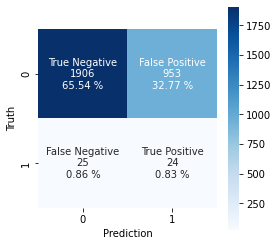

In [ ]:
graph_and_stats(death_model_u, X_death_valid, y_death_valid)

Log Loss: 11.380865963427025 

Accuracy: 0.6704978090654407
Balenced Accuracy: 0.8337079466357309
Null error rate: 106.91472868217055
Error rate: 0.3295021909345593
True Positive Rate: 1.0
False Positive Rate: 0.3325841067285383
True Negitive Rate: 0.6674158932714617
False Negitive Rate: 0.0
Precision: 0.027353689567430027
F-measure: 0.05325077399380805 



<Figure size 1080x432 with 0 Axes>

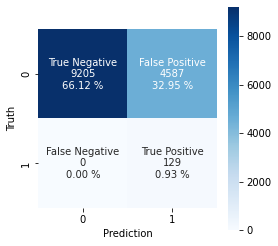

In [ ]:
graph_and_stats(death_model_u, X_death_train, y_death_train)

##Death with oversampling


In [ ]:
sampler = SMOTE(random_state = 0)

X_death_resampled_o, y_death_resampled_o = sampler.fit_resample(X_death_train,
                                                                y_death_train)

# Getting data in the right format
X_death_resampled_o = pd.DataFrame(X_death_resampled_o,
                                   columns=X_death_valid.columns)
y_death_resampled_o = pd.Series(y_death_resampled_o)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
death_model_o = XGBClassifier(
                            early_stopping_rounds=10,
                            lr = 0.05,
                            n_estimators=1000,
                            verbosity=1,
                            max_deapth=6,
                            )

death_model_o.fit(X_death_resampled_o, y_death_resampled_o)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=10,
              gamma=0, learning_rate=0.1, lr=0.05, max_deapth=6,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
              n_estimators=1000, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

Log Loss: 0.7838973984930714 

Accuracy: 0.9773039889958735
Balenced Accuracy: 0.5070561278026425
Null error rate: 58.3469387755102
Error rate: 0.02269601100412655
True Positive Rate: 0.02040816326530612
False Positive Rate: 0.0062959076600209865
True Negitive Rate: 0.993704092339979
False Negitive Rate: 0.9795918367346939
Precision: 0.05263157894736842
F-measure: 0.02941176470588235 



<Figure size 1080x432 with 0 Axes>

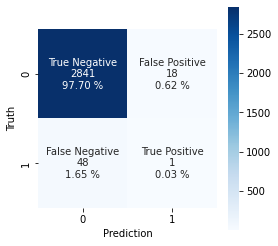

In [ ]:
graph_and_stats(death_model_o, X_death_valid, y_death_valid)

Log Loss: 0.2158519607465055 

Accuracy: 0.9937504489619998
Balenced Accuracy: 0.6704701298584507
Null error rate: 106.91472868217055
Error rate: 0.006249551038000144
True Positive Rate: 0.34108527131782945
False Positive Rate: 0.00014501160092807424
True Negitive Rate: 0.9998549883990719
False Negitive Rate: 0.6589147286821705
Precision: 0.9565217391304348
F-measure: 0.5028571428571429 



<Figure size 1080x432 with 0 Axes>

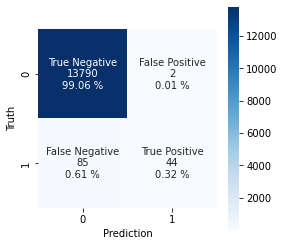

In [ ]:
graph_and_stats(death_model_o, X_death_train, y_death_train)